# 09. Comparison of Model System Scales

## Numerical experiments - Week 04/2025

_Boyan Mihaylov, MSc Computational Science (UVA/VU)_

## Prerequisite libraries

In [1]:
using PyPlot
using Revise

Revise.includet("./conversions.jl")
Revise.includet("./diffusion.jl")
Revise.includet("./plotting.jl")
Revise.includet("./setup.jl")
Revise.includet("./solver.jl")
using .Conversions
using .Diffusion
using .Plotting

## 1. Revision of scale assumptions - 3 options

### 1.1. Spore-scale simulation

The diffusion model developed so far is based on the discretisation of space using a single spore diameter as a spatial increment. This leads to a straightforward abstraction of the spore as a special node on the lattice which differs in its concentration contribution from the nodes of the extracellular medium. However, it could be argued that this discretisation is too arbitrary, too rough or leading to incoherences in the interpretation of the interface between spore and medium. For this reason, two additional alternative schemes are proposed.

### 1.2. Super-spore-scale simulation

First, inspired by the approach taken in the derivation of the analytical scheme in Notebook 7, it can be assumed that the spore source is of negligible size compared to the lattice resolution and that a single lattice site is a discrete box that _contains_ the spore, but their boundaries are not coincident. The spore can therefore be seen as a singular source which is not significantly large to pose an obstacle for diffusion within the box, but adds new concentration to the box with a rate based on the concentration difference between the spore and the medium. In this sense, the slow-permeating sub-system of the spore is spatially removed from the sub-system of the medium lattice, but they do communicate via the entry node assumed to contain the spore. The concentration drop between the spore and its containing cell evolves over time as follows:

$$
\begin{equation}
\frac{d{(c_{\textrm{in}}-c_{\textrm{out}})}}{dt}=-\frac{AP_s}{V}(c_{\textrm{in}}-c_{\textrm{out}})
\end{equation}
$$

This can be rewritten as

$$
\begin{equation}
\frac{d{c_{\textrm{in}}}}{dt}-\frac{d{c_{\textrm{out}}}}{dt}=-\frac{AP_s}{V}(c_{\textrm{in}}-c_{\textrm{out}}).
\end{equation}
$$

The derivative $\frac{d{c_{\textrm{out}}}}{dt}$ is approximated by a finite difference scheme:

$$
\begin{equation}
\frac{d{c_{\textrm{out}}}}{dt}\approx\frac{c_{\textrm{out}}(t+\delta{t})-c_{\textrm{out}}(t)}{\delta{t}}
\end{equation}
$$

Similarly,

$$
\begin{equation}
\frac{d{c_{\textrm{in}}}}{dt}\approx\frac{c_{\textrm{in}}(t+\delta{t})-c_{\textrm{in}}(t)}{\delta{t}}
\end{equation}
$$

Using these discretisations, the update of the spore concentration can be expressed as

$$
\begin{equation}
c_{\textrm{in}}(t+\delta{t})=c_{\textrm{out}}(t+\delta{t})+c_{\textrm{in}}(t)-c_{\textrm{out}}(t)-\frac{AP_s}{V}\delta{t}(c_{\textrm{in}}(t)-c_{\textrm{out}}(t))=c_{\textrm{out}}(t+\delta{t})+(c_{\textrm{in}}(t)-c_{\textrm{out}}(t))\left(1-\frac{AP_s}{V}\delta{t}\right).
\end{equation}
$$

The problem arising here is the interdependence between $c_{\textrm{in}}(t+\delta{t})$ and $c_{\textrm{out}}(t+\delta{t})$. This can be resolved by implementing a half-step for updating the concentration drop:

$$
\begin{equation}
\Delta{c}^{(1/2)}=(c_{\textrm{in}}(t)-c_{\textrm{out}}(t))\left(1-\frac{AP_s}{2V}\delta{t}\right).
\end{equation}
$$

The outside concentration in the spore-containing volume is then updated as a mixture of free diffusion with neighbour cells of the medium and the added concentration from the source:

$$
\begin{equation}
c_{\textrm{out}}(t+\delta{t})=c_{\textrm{out}}(t)+\delta{t}\left[D\nabla^2c_{\textrm{out}}(t)+\frac{AP_s}{V}\Delta{c}^{(1/2)}\right].
\end{equation}
$$

Finally, the inside concentration at a full time step can be completed:

$$
\begin{equation}
c_{\textrm{in}}(t+\delta{t})=c_{\textrm{out}}(t+\delta{t})+\Delta{c}^{(1/2)}\left(1-\frac{AP_s}{2V}\delta{t}\right).
\end{equation}
$$

The assumptions in this scheme are more aligned to the analytical solution derived previously:

$$
\begin{equation}
c(\vec{r},t)=\frac{c_0\sqrt{AP_sV}}{8\pi D^{3/2}}e^{-\frac{P_sAt}{V}}\sum_{\substack{i,j,k \\ |\Delta{\vec{r}}_{ijk}|\le R_{\textrm{diff}}}}{\left[\exp{\left(-\sqrt{\frac{|\Delta{\vec{r}}_{ijk}|^2 P_sA}{DV}}\right)}\textrm{erfc}{\left(\sqrt{\frac{P_sA}{Vt}}-\sqrt{\frac{|\Delta{\vec{r}}_{ijk}|^2 t}{4D}}\right)}\right]}.\tag{2}
\end{equation}
$$

To test if the results also show alignment, the concentration at the spore, $c_{\textrm{in}}$, is determined analytically. This takes into account the fact that the internal concentration decays as

$$
\begin{equation}
\frac{d{c_{\textrm{in}}{(\vec{r},t)}}}{d{t}}=-\frac{AP_s}{V}\left[c_{\textrm{in}}{(\vec{r},t)}-c_{\textrm{out}}{(\vec{r},t)}\right].
\tag{3}
\end{equation}
$$

In the case of multiple (periodically repeating) spores, the outside concentration is a mixture of the contributions of the measured spore and the neighbours in its vicinity:

$$
\begin{equation}
c_{\textrm{out}}{(\vec{r},t)}=c_{\textrm{out}}^{\textrm{(self)}}{(\vec{r},t)}+c_{\textrm{out}}^{\textrm{(neighbours)}}{(\vec{r},t)}=c_{\textrm{out}}^{\textrm{(o)}}{(\vec{r},t)}+\sum_{i\ne o}^M{c_{\textrm{out}}^{\textrm{(i)}}{(\vec{r},t)}},
\end{equation}
$$

where $o$ denotes the index of the measured source (the origin). In general, the concentration released in the medium at position $\vec{r}$, consisting of all source contributions, can be computed by Equation 2. In it, the contributions from separate sources can be clearly distinguished:

$$
\begin{equation}
\sum_i^M{c_{\textrm{out}}^{(i)}}{(\Delta{\vec{r}},t)}=\frac{c_0\sqrt{AP_sV}}{8\pi D^{3/2}}e^{-\frac{P_sAt}{V}}\sum_i^M{\left[\exp{\left(-\sqrt{\frac{|\Delta{\vec{r}}|^2 P_sA}{DV}}\right)}\textrm{erfc}{\left(\sqrt{\frac{P_sA}{Vt}}-\sqrt{\frac{|\Delta{\vec{r}}|^2 t}{4D}}\right)}\right]}.
\end{equation}
$$

Therefore, the release from a single source can be expressed as

$$
\begin{equation}
c_{\textrm{out}}^{(i)}{(\Delta{\vec{r}},t)}=\frac{c_0\sqrt{AP_sV}}{8\pi D^{3/2}}e^{-\frac{P_sAt}{V}}\exp{\left(-\sqrt{\frac{|\Delta{\vec{r}}|^2 P_sA}{DV}}\right)}\textrm{erfc}{\left(\sqrt{\frac{P_sA}{Vt}}-\sqrt{\frac{|\Delta{\vec{r}}|^2 t}{4D}}\right)}.
\end{equation}
$$

At the origin source, $\Delta{\vec{r}}$ is zero, which reduces the term to

$$
\begin{equation}
c_{\textrm{out}}^{(o)}{(\Delta{\vec{r}},t)}=\frac{c_0\sqrt{AP_sV}}{8\pi D^{3/2}}e^{-\frac{P_sAt}{V}}\textrm{erfc}{\left(\sqrt{\frac{P_sA}{Vt}}\right)}.
\end{equation}
$$

In the limit of infinite sources, the sum over all source contributions can be approximated by an integral, accounting for the density of the sources, $\rho_s$:

$$
\begin{equation}
\sum_i^\infty{c_{\textrm{out}}^{(i)}}{(\Delta{\vec{r}},t)}\approx\frac{c_0\sqrt{AP_sV}}{8\pi D^{3/2}}e^{-\frac{P_sAt}{V}}\rho_s\int_{\mathbb{R}^3}{d{\vec{r}}\left[\exp{\left(-\sqrt{\frac{|\Delta{\vec{r}}|^2 P_sA}{DV}}\right)}\textrm{erfc}{\left(\sqrt{\frac{P_sA}{Vt}}-\sqrt{\frac{|\Delta{\vec{r}}|^2 t}{4D}}\right)}\right]}.
\end{equation}
$$

Converting this to an integral to polar space with a radius $r=\sqrt{|\Delta{\vec{r}}|^2}$ yields

$$
\begin{equation}
\sum_i^\infty{c_{\textrm{out}}^{(i)}}{(r,t)}=\frac{c_0\sqrt{AP_sV}}{8\pi D^{3/2}}e^{-\frac{P_sAt}{V}}\rho_s\int_0^\infty{d{r}\ r^2\left[\exp{\left(-\sqrt{\frac{r^2 P_sA}{DV}}\right)}\textrm{erfc}{\left(\sqrt{\frac{P_sA}{Vt}}-\sqrt{\frac{r^2 t}{4D}}\right)}\right]\int_0^{2\pi}{d{\theta}\sin{\theta}\int_0^\pi{d{\phi}}}},
\end{equation}
$$

$$
\begin{equation}
\sum_i^\infty{c_{\textrm{out}}^{(i)}}{(r,t)}=\frac{\rho_sc_0\sqrt{AP_sV}}{8\pi D^{3/2}}e^{-\frac{P_sAt}{V}}4\pi\int_0^\infty{d{r}\ r^2\left[\exp{\left(-r\sqrt{\frac{P_sA}{DV}}\right)}\textrm{erfc}{\left(\sqrt{\frac{P_sA}{Vt}}-r\sqrt{\frac{ t}{4D}}\right)}\right]},
\end{equation}
$$

$$
\begin{equation}
\sum_i^\infty{c_{\textrm{out}}^{(i)}}{(r,t)}=\frac{\rho_sc_0\sqrt{AP_sV}}{2 D^{3/2}}e^{-\frac{P_sAt}{V}}\int_0^\infty{d{r}\ r^2\left[\exp{\left(-r\sqrt{\frac{ P_sA}{DV}}\right)}\textrm{erfc}{\left(\sqrt{\frac{P_sA}{Vt}}-r\sqrt{\frac{ t}{4D}}\right)}\right]}.
\end{equation}
$$

To avoid over-counting the contribution of the origin source, the integral can be taken in an interval from a small distance $\epsilon$ to an upper limit relevant for diffusion ($R_{\textrm{diff}}$). Thus, the outside concentration contributed by the neighbours is

$$
\begin{equation}
c_{\textrm{out}}^{\textrm{(neighbours)}}{(r,t)}\approx\frac{\rho_sc_0\sqrt{AP_sV}}{2 D^{3/2}}e^{-\frac{P_sAt}{V}}\int_\epsilon^{R_{\textrm{diff}}}{d{r}\ r^2\left[\exp{\left(-r\sqrt{\frac{ P_sA}{DV}}\right)}\textrm{erfc}{\left(\sqrt{\frac{P_sA}{Vt}}-r\sqrt{\frac{ t}{4D}}\right)}\right]}.
\end{equation}
$$

The integral is difficult to solve analytically, so it is numerically evaluated. This leads to a total outside concentration at the measured site:

$$
\begin{equation}
c_{\textrm{out}}{(0,t)}=\frac{c_0\sqrt{AP_sV}}{8\pi D^{3/2}}\left[e^{-\frac{P_sAt}{V}}\textrm{erfc}{\left(\sqrt{\frac{P_sA}{Vt}}\right)}+4\pi\rho_s\int_\epsilon^{R_{\textrm{diff}}}{d{r}\ r^2\left[\exp{\left(-r\sqrt{\frac{ P_sA}{DV}}\right)}\textrm{erfc}{\left(\sqrt{\frac{P_sA}{Vt}}-r\sqrt{\frac{ t}{4D}}\right)}\right]}\right]
\end{equation}
$$

Finally, the remaining concentration in the spore is computed from Equation 3 as

$$
\begin{equation}
c_{\textrm{in}}{(0,t)} = c_0e^{-\frac{P_sAt}{V}} + \frac{AP_s}{V}\int_0^t{e^{-\frac{P_sA(t-t')}{V}}c_{\textrm{out}}{(0,t')}d{t'}}.
\end{equation}
$$

### 1.3. Cell-wall-scale simulation

A second option considers the opposite scenario --- a much more fine-grain lattice, such that the detail of the spore's spherical shape can be captured. This becomes important in observing the spatial articulation of spore packings caused by aggregation and furthermore improves the accuracy of the diffusion simulation by considering scales closer to the infinitessimal limit.

Since the high resolution of the lattice requires significantly increased computation, drastic optimisation measures are required. For this purpose, each cell in the lattice performs a dynamic check of its distance to the spore centre, given the spore radius. If the cell falls within this radius but has excluded neighbours (in its von Neumann neighbourhood), then it is considered a member of the cell wall - the source region governed by slow diffusion. If it is excluded from the radius along with all of its neighbours, it is a member of the medium region. If the cell and all of its neighbours are within the radius, it is excluded from the computation.

Since the other two methods compute the concentration relative to the entire spore volume, as opposed to just the cell wall volume, the resulting lattice concentrations from the high-resolution procedure are related to the entirety of the spore sphere. This is performed by first multiplying each concentration by $d{x}^3$, them summing the inhibitor quantities from all cell wall nodes and dividing them by the spore volume. This calculation is perfrmed on the central spore only, disregarding the neighbour concentrations.

## 2. Comparative experiments

### 2.1. Single-spore simulations

The two newly proposed options are constructed and tested against the original discretisation scheme, applying different resolutions on a lattice with the similar spatial dimensions and simulating inhibitor diffusion with a single spore. The concentration at the spore is recorded over time and compared among the numerical schemes as well as to the respective analytical solution. A lattice size of $L=N\times\delta{x}=320\mu\textrm{m}$ is used for the medium and low-resolution simulations. Due to memory limits, the high-resolution simulation is only run on a lattice of $N=256$ subdivisions, amounting to $51.2$ micrometers, but its concentration evolution is compared to an analytical counterpart with the respective spore-to-spore distance.

In [ ]:
# Global parameters
D = 600 # microns^2/s
Ps_fit = 0.0002675353069511818 # microns/s
t_max = 100#300#10.0#14400 # s
c0_spore = 1.5 # x10^(-5) M
c0_cw = 3.84 # x10^(-5) M
spore_diameter = 5 # microns
K = 1#316.23 # partition coefficient, set to 1 since we don't necessarily deal with lipid membranes

# ----- Analytical solution -----
c_out = 0.0 # M
n_times = 1000
times = LinRange(0, t_max, n_times)

# Cube spore
V_spore_cube = spore_diameter^3 # microns^3
A_spore_cube = 6 * spore_diameter^2 # microns^2
c_analytical_cube = permeation_time_dependent_analytical(c0_spore, c_out, times, Ps_fit, A_spore_cube, V_spore_cube)
println("Analytical solution for spore with V=$V_spore_cube and A=$A_spore_cube: ", c_analytical_cube[end])

# Sphere spore
V_spore_sphere = 4π * (spore_diameter / 2)^3 / 3 # microns^3
A_spore_sphere = 4π * (spore_diameter / 2)^2 # microns^2
c_analytical_sphere = permeation_time_dependent_analytical(c0_spore, c_out, times, Ps_fit, A_spore_sphere, V_spore_sphere)
println("Analytical solution for spore with V=$V_spore_sphere and A=$A_spore_sphere: ", c_analytical_sphere[end])

# Periodic sources
L = 320 # microns, corresponds to medium and low-resolution lattice size
src_density = 1 / cubic_um_to_mL(L^3) # sources per micron^3
c_analytical_ms_sparse = slow_release_src_grid_src(src_density, c0_spore, times, D, Ps_fit, A_spore_sphere, V_spore_sphere, n_times)
println("Analytical solution for periodic sources (L=$L um): ", c_analytical_ms_sparse[end])

L = 51.2 # microns, corresponds to high-resolution lattice size
src_density = 1 / cubic_um_to_mL(L^3) # sources per micron^3
c_analytical_ms_dense = slow_release_src_grid_src(src_density, c0_spore, times, D, Ps_fit, A_spore_sphere, V_spore_sphere, n_times)
println("Analytical solution for periodic sources (L=$L um): ", c_analytical_ms_dense[end])

# ----- Numerical solution -----
n_save_frames = 100

# Mid resolution
N_mid = 64
dt = 0.005
spore_idx = (N_mid ÷ 2, N_mid ÷ 2, N_mid ÷ 2)
c_init = zeros(N_mid, N_mid, N_mid)
c_init[spore_idx...] = c0_spore
c_numerical_mr, times_numerical_mr, _ = diffusion_time_dependent_GPU(c_init, t_max; D, Ps=Ps_fit, dt=dt, dx=spore_diameter, n_save_frames=n_save_frames, spore_idx=spore_idx)
println("Numerical solution (mid-resolution): ", c_numerical_mr[end, spore_idx...])

# Low resolution
scale_factor = 4 # 1 cell is 4 spore diameters long
N_lo = N_mid ÷ scale_factor
dt = 0.1
dx = spore_diameter * scale_factor
spore_vol_idx = (N_lo ÷ 2, N_lo ÷ 2, N_lo ÷ 2)
c_init = zeros(N_lo, N_lo, N_lo)
_, c_numerical_lr, times_numerical_lr, _ = diffusion_time_dependent_GPU_low_res(c_init, c0_spore, t_max; D=D, Pₛ=Ps_fit, 
                                                                                A=A_spore_sphere, V=V_spore_sphere, dt=dt, dx=dx,
                                                                                n_save_frames=n_save_frames, spore_vol_idx=spore_vol_idx)
println("Numerical solution (low-resolution): ", c_numerical_lr[end])

# High resolution (implicit)
N_hi = 256 # 1 cell is 0.20 um long
dt = 0.05
dx = 0.2 # half cell wall thickness
Db = Ps_fit * dx  / K # compute diffusion coefficient from permeability
spore_center_idx = (N_hi ÷ 2, N_hi ÷ 2, N_hi ÷ 2)
c_init = zeros(Float64, N_hi, N_hi, N_hi)
# Pay attention to re-scaled parameters!
c_frames_hr, c_numerical_hr, times_numerical_hr, region_ids, _ = diffusion_time_dependent_GPU_hi_res_implicit(c_init, c0_cw, [spore_center_idx], spore_diameter / 2, t_max;
                                                                                                                D=D^2, Db=Db, dt=dt, dx=dx,
                                                                                                                n_save_frames=n_save_frames, crank_nicolson=false)
println("Numerical solution (high-resolution): ", c_numerical_hr[end])

Analytical solution for spore with V=125 and A=150: 1.4526084499209286
Analytical solution for spore with V=65.44984694978736 and A=78.53981633974483: 1.4526084499209286
Analytical solution for periodic sources (L=320 um): 1.4526119140807545
Analytical solution for periodic sources (L=51.2 um): 1.4534541920659032
3D simulation
Using D = 600, Db = 0.0013376765347559091, Ps = 0.0002675353069511818
Storage arrays allocated.
Numerical solution (mid-resolution): 1.4523162841796875
3D simulation
Using D = 600, Ps = 0.0002675353069511818
Storage arrays allocated.
Numerical solution (low-resolution): 1.4526937007904053
Using D = 600.0, Db = 5.350706139023637e-5, Dcw = 2.6753531888037245e-5
D*dt/dx2 = 749.9999999999999, Db*dt/dx2 = 6.688382673779544e-5, Dcw*dt/dx2 = 3.344191486004655e-5
Timescale for accuracy: 6.666666666666668e-5
Spore radius in lattice units: 12.5
Storage arrays allocated.
Frame 100 saved.Numerical solution (high-resolution): 1.465239912369426


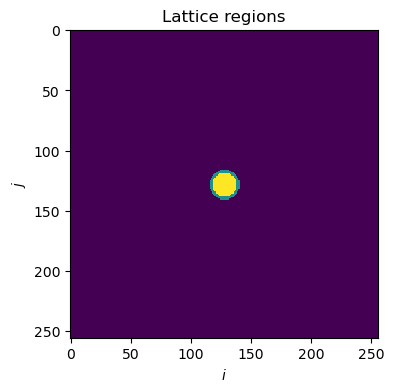

In [8]:
plot_lattice_regions(region_ids)

Plotting frames: [1, 2, 67, 101]


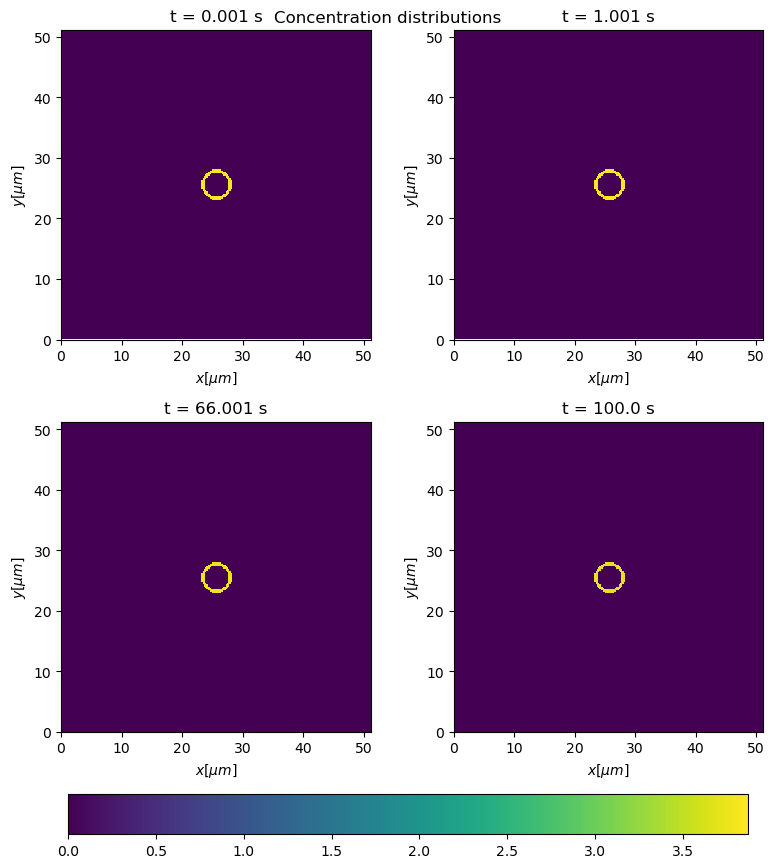

In [9]:
plot_concentration_lattice(c_frames_hr, dx,
                            frame_indices=[1, 2, round(Int, size(c_frames_hr)[1]*0.666), size(c_frames_hr)[1]],
                            times=times_numerical_hr, title="Concentration distributions")

Fitted exponential: (1.5000726284647792, -0.0003209275840179994)
Fitted exponential: (1.500128335732824, -0.0003230429854947127)
Fitted exponential: (1.4999228847812032, -0.0003024392465257779)
Fitted exponential: (1.4999993281375015, -0.0003210193640659814)
Fitted exponential: (1.4998360289033816, -0.00031542732671472815)


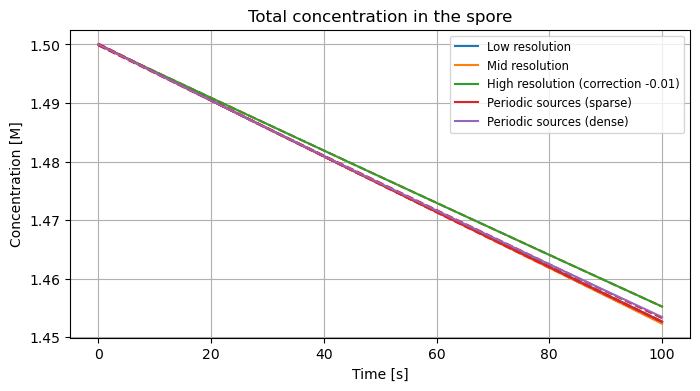

In [53]:
compare_concentration_evolutions([c_numerical_lr, c_numerical_mr[:, spore_idx...], c_numerical_hr[:].-0.01, c_analytical_ms_sparse, c_analytical_ms_dense],
                                    [times_numerical_lr, times_numerical_mr, times_numerical_hr, collect(times), collect(times)],
                                    ["Low resolution", "Mid resolution", "High resolution (correction -0.01)", "Periodic sources (sparse)", "Periodic sources (dense)"], logy=false, fit_exp=true)

The resulting plots indicate relatively good alignment, with some discretisation error reflected in an overestimation of the spore concentration in the high-resolution scheme. Nonetheless, all three scales exhibit the same decay exponent (approx. -0.00032), which verifies that they can accurately represent the same system with different levels of granularity. The analytical estimation of the concentration under periodic releasing sources exhibits slightly higher values than the medium and low-resolution schemes with comparable lattice size, but underestimates the concentration compared to the low-resolution.

### 2.2. Multi-spore simulations

A study of particular relevance for the newly derived analytical solution with multiple sources is whether the saturation effects at high spore densities are captured accurately. To examine this, a series of experiments captures the concentration evolutions at gradually increasing lattice sizes in the low, medium and high-resolution setups for $t_{\textrm{max}}=1$ hour and compares them to an analytical solution accounting for an equivalent spore density.

In [2]:
# Global parameters
D = 600 # microns^2/s
Ps_fit = 0.0002675353069511818 # microns/s
t_max = 14400 # s
c0_spore = 1.5 # x10^(-5) M
c0_cw = 3.84 # x10^(-5) M
spore_diameter = 5 # microns
K = 1#316.23 # partition coefficient, set to 1 since we don't necessarily deal with lipid membranes

# ----- Analytical solution -----
V_spore_sphere = 4π * (spore_diameter / 2)^3 / 3 # microns^3
A_spore_sphere = 4π * (spore_diameter / 2)^2 # microns^2
n_times = 1000
times = LinRange(0, t_max, n_times)
Ls_analytical = LinRange(24, 52, 15)
c_analytical_Ls = zeros(length(Ls_analytical), n_times)
for (i, L) in enumerate(Ls_analytical)
    src_density = 1 / cubic_um_to_mL(L^3) # sources per micron^3
    c_analytical_Ls[i, :] = slow_release_src_grid_src(src_density, c0_spore, times, D, Ps_fit, A_spore_sphere, V_spore_sphere, n_times)
end

# ----- Numerical solutions -----
n_save_frames = 100

# Low resolution
dx = 20
dt = 0.1
Ns = [2, 3]
Ls_numerical_lo = Ns .* dx
c_numerical_lo_Ls = zeros(length(Ns), n_save_frames+1)
for (i, N) in enumerate(Ns)
    println("Low resolution: ", N)
    spore_vol_idx = (N ÷ 2, N ÷ 2, N ÷ 2)
    c_init = zeros(N, N, N)
    _, c_numerical_lo, times_numerical_lo, _ = diffusion_time_dependent_GPU_low_res(c_init, c0_spore, t_max; D=D, Pₛ=Ps_fit, 
                                                                                    A=A_spore_sphere, V=V_spore_sphere, dt=dt, dx=dx,
                                                                                    n_save_frames=n_save_frames, spore_vol_idx=spore_vol_idx)
    c_numerical_lo_Ls[i, :] .= c_numerical_lo
end

# Mid resolution
dx = 1
dt = 0.005
Ns = Int.(LinRange(24, 56, 9))
Ls_numerical_mr = Ns .* dx
c_numerical_mr_Ls = zeros(length(Ns), n_save_frames+1)
for (i, N) in enumerate(Ns)
    println("Mid resolution: ", N)
    spore_idx = (N ÷ 2, N ÷ 2, N ÷ 2)
    c_init = zeros(N, N, N)
    c_init[spore_idx...] = c0_spore
    c_numerical_mr, times_numerical_mr, _ = diffusion_time_dependent_GPU(c_init, t_max; D, Ps=Ps_fit, dt=dt, dx=spore_diameter, n_save_frames=n_save_frames, spore_idx=spore_idx)
    println(size(c_numerical_mr))
    c_numerical_mr_Ls[i, :] .= c_numerical_mr[:, spore_idx...]
end

# High resolution (implicit)
dx = 0.2
dt = 0.05
Db = Ps_fit * dx  / K # compute diffusion coefficient from permeability
Ns = Int.(LinRange(128, 256, 9))
Ls_numerical_hr = Ns .* dx
c_numerical_hr_Ls = zeros(length(Ns), n_save_frames+1)
for (i, N) in enumerate(Ns)
    println("High resolution: ", N)
    spore_center_idx = (N ÷ 2, N ÷ 2, N ÷ 2)
    c_init = zeros(Float64, N, N, N)
    _, c_numerical_hr, times_numerical_hr, _, _ = diffusion_time_dependent_GPU_hi_res_implicit(c_init, c0_cw, [spore_center_idx], spore_diameter / 2, t_max;
                                                                                                D=D^2, Db=Db, dt=dt, dx=dx,
                                                                                                n_save_frames=n_save_frames, crank_nicolson=false)
    c_numerical_hr_Ls[i, :] .= c_numerical_hr
end

times_numerical = collect(LinRange(0, t_max, n_save_frames+1))

Low resolution: 2
3D simulation
Using D = 600, Ps = 0.0002675353069511818
Storage arrays allocated.
Low resolution: 3
3D simulation
Using D = 600, Ps = 0.0002675353069511818
Storage arrays allocated.
Mid resolution: 24
3D simulation
Using D = 600, Db = 0.0013376765347559091, Ps = 0.0002675353069511818
Storage arrays allocated.
(101, 24, 24, 24)
Mid resolution: 28
3D simulation
Using D = 600, Db = 0.0013376765347559091, Ps = 0.0002675353069511818
Storage arrays allocated.
(101, 28, 28, 28)
Mid resolution: 32
3D simulation
Using D = 600, Db = 0.0013376765347559091, Ps = 0.0002675353069511818
Storage arrays allocated.
(101, 32, 32, 32)
Mid resolution: 36
3D simulation
Using D = 600, Db = 0.0013376765347559091, Ps = 0.0002675353069511818
Storage arrays allocated.
(101, 36, 36, 36)
Mid resolution: 40
3D simulation
Using D = 600, Db = 0.0013376765347559091, Ps = 0.0002675353069511818
Storage arrays allocated.
(101, 40, 40, 40)
Mid resolution: 44
3D simulation
Using D = 600, Db = 0.0013376765

101-element Vector{Float64}:
     0.0
   144.0
   288.0
   432.0
   576.0
   720.0
   864.0
  1008.0000000000001
  1152.0
  1296.0
     ⋮
 13248.0
 13392.0
 13536.0
 13680.0
 13824.0
 13968.0
 14112.0
 14256.0
 14400.0

In [6]:
c_numerical_mr_Ls

9×101 Matrix{Float64}:
 1.5  1.48283  1.46567  1.4485  1.43218  …  0.483057  0.477478  0.471961
 1.5  1.48283  1.46567  1.4485  1.43218     0.483043  0.477464  0.471947
 1.5  1.48283  1.46567  1.4485  1.43218     0.483036  0.477457  0.471939
 1.5  1.48283  1.46567  1.4485  1.43218     0.483031  0.477452  0.471934
 1.5  1.48283  1.46567  1.4485  1.43218     0.483028  0.477449  0.471931
 1.5  1.48283  1.46567  1.4485  1.43218  …  0.483026  0.477447  0.471929
 1.5  1.48283  1.46567  1.4485  1.43218     0.483025  0.477446  0.471927
 1.5  1.48283  1.46567  1.4485  1.43218     0.483024  0.477445  0.471926
 1.5  1.48283  1.46567  1.4485  1.43218     0.483023  0.477444  0.471925

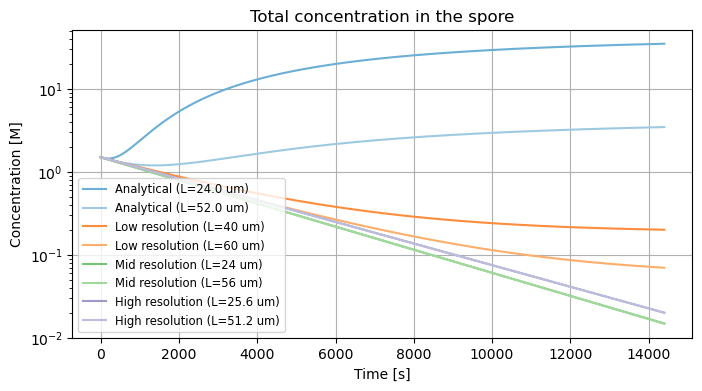

In [3]:
idx_A = 1
idx_B = 9

concentrations_groups = [[vec(c_analytical_Ls[1, :]), vec(c_analytical_Ls[15, :])],
                        [vec(c_numerical_lo_Ls[1, :]), vec(c_numerical_lo_Ls[2, :])],
                        [vec(c_numerical_mr_Ls[idx_A, :]), vec(c_numerical_mr_Ls[idx_B, :])],
                        [vec(c_numerical_hr_Ls[idx_A, :]), vec(c_numerical_hr_Ls[idx_B, :])]]
times_groups = [[collect(times), collect(times)],
                [times_numerical, times_numerical],
                [times_numerical, times_numerical],
                [times_numerical, times_numerical]]
labels = [["Analytical (L=$(Ls_analytical[1]) um)", "Analytical (L=$(Ls_analytical[15]) um)"],
        ["Low resolution (L=$(Ls_numerical_lo[1]) um)", "Low resolution (L=$(Ls_numerical_lo[2]) um)"],
        ["Mid resolution (L=$(Ls_numerical_mr[idx_A]) um)", "Mid resolution (L=$(Ls_numerical_mr[idx_B]) um)"],
        ["High resolution (L=$(Ls_numerical_hr[idx_A]) um)", "High resolution (L=$(Ls_numerical_hr[idx_B]) um)"]]

# concentrations_groups = [[vec(c_numerical_lo_Ls[1, :]), vec(c_numerical_lo_Ls[2, :])],
#                         [vec(c_numerical_mr_Ls[idx_A, :]), vec(c_numerical_mr_Ls[idx_B, :])],
#                         [vec(c_numerical_hr_Ls[idx_A, :]), vec(c_numerical_hr_Ls[idx_B, :])]]
# times_groups = [[times_numerical, times_numerical],
#                 [times_numerical, times_numerical],
#                 [times_numerical, times_numerical]]
# labels = [["Low resolution (L=$(Ls_numerical_lo[1]) um)", "Low resolution (L=$(Ls_numerical_lo[2]) um)"],
#         ["Mid resolution (L=$(Ls_numerical_mr[idx_A]) um)", "Mid resolution (L=$(Ls_numerical_mr[idx_B]) um)"],
#         ["High resolution (L=$(Ls_numerical_hr[idx_A]) um)", "High resolution (L=$(Ls_numerical_hr[idx_B]) um)"]]

# concentrations_groups = [[vec(c_numerical_lo_Ls[1, :]), vec(c_numerical_lo_Ls[2, :])]]
# times_groups = [[times_numerical, times_numerical],
#         [times_numerical, times_numerical]]
# labels = [["Low resolution (L=$(Ls_numerical_lo[1]) um)", "Low resolution (L=$(Ls_numerical_lo[2]) um)"]]

# concentrations_groups = [[vec(c_numerical_mr_Ls[idx_A, :]), vec(c_numerical_mr_Ls[idx_B, :])]]
# times_groups = [[times_numerical, times_numerical]]
# labels = [["Mid resolution (L=$(Ls_numerical_mr[idx_A]) um)", "Mid resolution (L=$(Ls_numerical_mr[idx_B]) um)"]]

compare_concentration_evolution_groups(concentrations_groups, times_groups, labels, logy=true, fit_exp=false)

The coarsest simulation overestimates the concentrations, understandably due to the extreme level of discretisation at 2 lattice subdivisions in each dimension. When increased to 3 subdivisions, the low-resolution scheme produces results relatively aligned with the high-resolution simulation at both $L=25.6$ micrometers and $L=51.2$ micrometers lattice size.

Despite operating on radically different lattice sizes, the high-resolution simulations seem to diverge only slightly over the course of time, after which their results come close together again at $t=3600$ seconds. The trajectory they most coincide with is the low-resolution simulation at a lattice size of $L=60$ micrometers.

The medium-resolution simulations exhibit even less divergence, with both trajectories remaining aligned over the one-hour course. The results exhibited, however, are markedly below the ones from the high-resolution simulation --- a trend which was already visible in the previous comparison.

## 3. Additional studies

### 3.1. Sparse matrix exercise

In [ ]:
using SparseArrays
using IterTools

In [ ]:
N = 20
rad = 5
spore_idx = (N ÷ 2, N ÷ 2)
medium_is, medium_js, medium_cs = [], [], []
cw_is, cw_js, cw_concs = [], [], []
for i in 1:N
    for j in 1:N
        steps = [-1, 0, 1]
        von_neumann_nbrs = collect(IterTools.product(steps, steps))
        excluded = false
        excluded_nbrs = 0
        for (di, dj) in von_neumann_nbrs
            if (i + di - spore_idx[1])^2 + (j + dj - spore_idx[2])^2 > rad^2
                if (di, dj) == (0, 0)
                    excluded = true
                    push!(medium_is, i)
                    push!(medium_js, j)
                    push!(medium_cs, 1.0)
                else
                    excluded_nbrs += 1
                end
            end
        end
        if !excluded && excluded_nbrs > 0
            push!(cw_is, i)
            push!(cw_js, j)
            push!(cw_concs, 1.0)
        end
    end
end
# nz_is = hcat(nz_is...)
# nx_js = hcat(nx_js...)
# nz_concs = hcat(nz_concs...)
medium_sparse = sparse(medium_is, medium_js, medium_cs, N, N)
cw_sparse = sparse(cw_is, cw_js, cw_concs, N, N)

20×20 SparseMatrixCSC{Any, Int64} with 36 stored entries:
⎡⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⠀⠀⢠⠖⠚⠒⢦⠀⠀⠀⎥
⎢⠀⠀⢺⠀⠀⠀⢸⠂⠀⠀⎥
⎢⠀⠀⠈⠓⠲⠒⠋⠀⠀⠀⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎦

### 3.2. Oscillation in the Crank-Nicholson scheme

The plot below shows the measured oscillations in the solutions from the Crank-Nelson implicit method at low time steps.

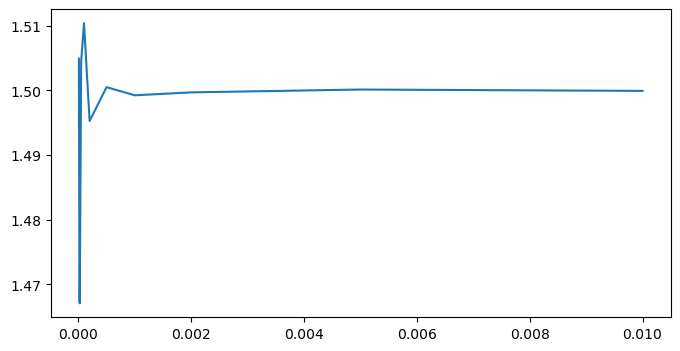

In [38]:
fig, ax = subplots(1, 1, figsize=(8, 4))
ax.plot([0.00001, 0.00002, 0.000025, 0.00005, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01],
    [1.5048929224400762, 1.4675215172683493, 1.467079706082919, 1.504441259753694, 1.5103601182596633, 1.4952611300259646, 1.5004846588950445, 1.4992288034937455, 1.4996793205407004, 1.5001188115480535, 1.499909844061341])
gcf()